# House Price Range Classification

**Problem statement:** Classify houses into price ranges (low, medium, high) using basic features like number of bedrooms, bathrooms, and square footage. Use Decision Trees or Random Forest for interpretable classification results.

This notebook expects the dataset to be placed at `data/Housing.csv`.


In [32]:
# Standard imports
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

DATA_PATH = r"../data/Housing.csv"
print('Loading', DATA_PATH)
df = pd.read_csv(DATA_PATH)
df.head()

Loading ../data/Housing.csv


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [33]:
# Detect columns and select features
cols = list(df.columns)
price_col = None
for c in cols:
    if 'price' in c.lower():
        price_col = c
        break
if price_col is None:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    price_col = numeric_cols[0]

# helper to find columns
def find_col(possible_names):
    for c in cols:
        lc = c.lower()
        for p in possible_names:
            if p in lc:
                return c
    return None

bed_col = find_col(['bed','br'])
bath_col = find_col(['bath','bathroom','ba'])
sqft_col = find_col(['sqft','square','area','size'])

numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c!=price_col]
if bed_col is None and len(numeric_cols)>0:
    bed_col = numeric_cols[0]
if bath_col is None and len(numeric_cols)>1:
    candidates = [c for c in numeric_cols if c not in [bed_col]]
    bath_col = candidates[0] if candidates else numeric_cols[0]
if sqft_col is None and len(numeric_cols)>2:
    candidates = [c for c in numeric_cols if c not in [bed_col, bath_col]]
    sqft_col = candidates[0] if candidates else (numeric_cols[0] if numeric_cols[0] not in [bed_col,bath_col] else numeric_cols[1])

features = [c for c in [bed_col, bath_col, sqft_col] if c is not None]
print('Detected features:', features)
print('Price column:', price_col)

Detected features: ['bedrooms', 'bathrooms', 'area']
Price column: price


In [34]:
# Create price_range target using tertiles
series_price = pd.to_numeric(df[price_col], errors='coerce').dropna()
if len(series_price) >= 3:
    q1 = series_price.quantile(1/3)
    q2 = series_price.quantile(2/3)
else:
    q1 = series_price.min(); q2 = series_price.max()

def price_range_label(x):
    x = float(x)
    if x <= q1:
        return 'low'
    elif x <= q2:
        return 'medium'
    else:
        return 'high'

work_df = df.dropna(subset=features+[price_col]).copy()
work_df['price_range'] = work_df[price_col].apply(price_range_label)
work_df[[features[0] if len(features)>0 else price_col, 'price_range']].head()

,bedrooms,price_range
0,4,high
1,4,high
2,3,high
3,4,high
4,4,high


In [35]:
# Train/test split and model training
X = work_df[features].astype(float)
le = LabelEncoder()
y = le.fit_transform(work_df['price_range'])

# handle few-sample cases
stratify_param = y if len(set(y))>1 and min([list(y).count(c) for c in set(y)])>1 else None
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=stratify_param)

dt = DecisionTreeClassifier(random_state=42, max_depth=6)
rf = RandomForestClassifier(random_state=42, n_estimators=200)

dt.fit(X_train, y_train)
rf.fit(X_train, y_train)

for name, model in [('Decision Tree', dt), ('Random Forest', rf)]:
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print('===', name, '===')
    print('Accuracy:', acc)
    print(classification_report(y_test, y_pred, target_names=le.classes_))


=== Decision Tree ===
Accuracy: 0.6055045871559633
              precision    recall  f1-score   support

        high       0.68      0.76      0.72        37
         low       0.70      0.70      0.70        37
      medium       0.39      0.34      0.36        35

    accuracy                           0.61       109
   macro avg       0.59      0.60      0.59       109
weighted avg       0.59      0.61      0.60       109

=== Random Forest ===
Accuracy: 0.5871559633027523
              precision    recall  f1-score   support

        high       0.73      0.65      0.69        37
         low       0.63      0.73      0.68        37
      medium       0.39      0.37      0.38        35

    accuracy                           0.59       109
   macro avg       0.58      0.58      0.58       109
weighted avg       0.59      0.59      0.58       109



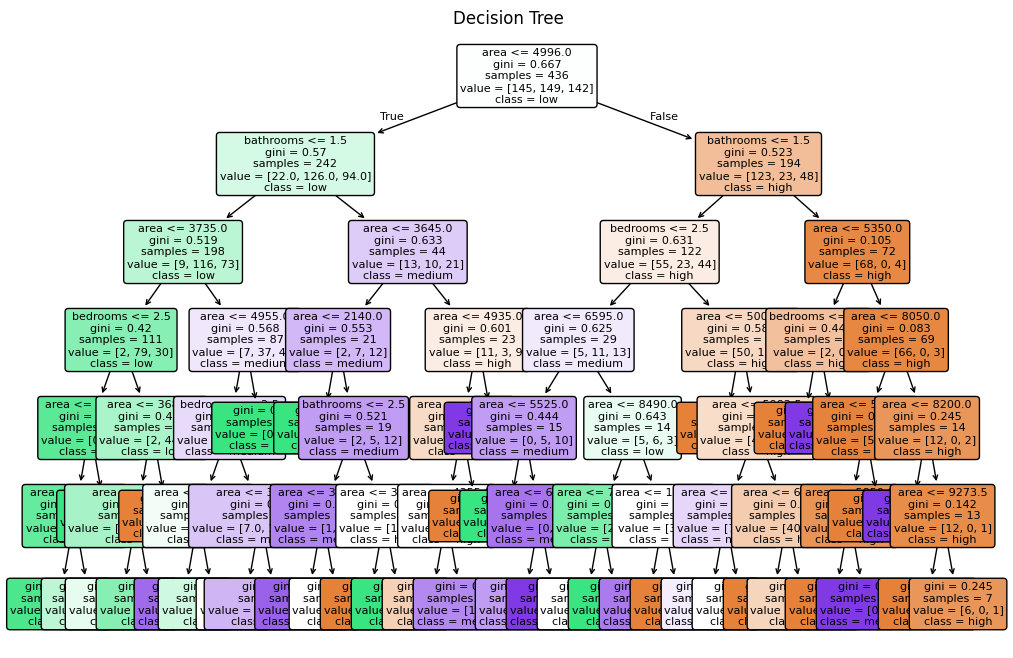

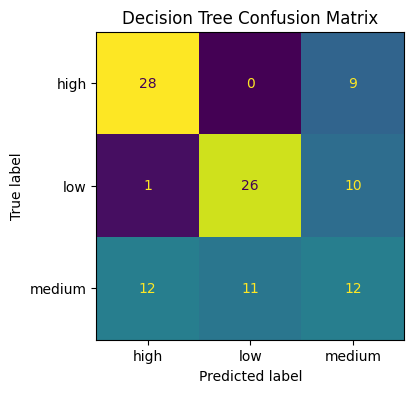

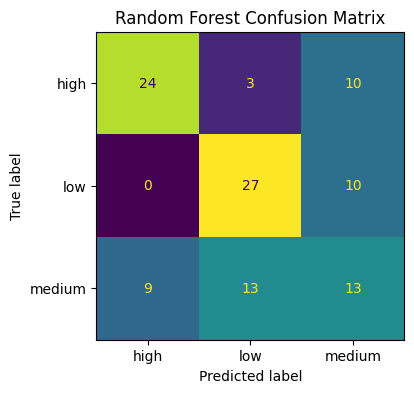

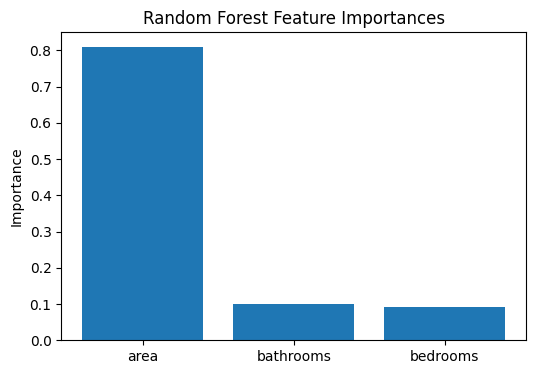

Plots saved to ../outputs


In [36]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import os
import numpy as np

# Save outputs in a folder outside the notebook folder
OUTPUTS_DIR = '../outputs'  # one level above current notebook folder
os.makedirs(OUTPUTS_DIR, exist_ok=True)

# Decision tree plot
plt.figure(figsize=(12,8))
plot_tree(dt, feature_names=features, class_names=le.classes_, filled=True, rounded=True, fontsize=8)
plt.title('Decision Tree')
dt_path = os.path.join(OUTPUTS_DIR, 'decision_tree_plot.png')
plt.savefig(dt_path, bbox_inches='tight')
plt.show()
plt.close()

# Confusion matrices
y_pred_dt = dt.predict(X_test)
y_pred_rf = rf.predict(X_test)

# Decision Tree Confusion Matrix
fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_dt), display_labels=le.classes_).plot(ax=ax, colorbar=False)
ax.set_title('Decision Tree Confusion Matrix')
cm_dt_path = os.path.join(OUTPUTS_DIR, 'confusion_matrix_dt.png')
fig.savefig(cm_dt_path, bbox_inches='tight')
plt.show()
plt.close(fig)

# Random Forest Confusion Matrix
fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_rf), display_labels=le.classes_).plot(ax=ax, colorbar=False)
ax.set_title('Random Forest Confusion Matrix')
cm_rf_path = os.path.join(OUTPUTS_DIR, 'confusion_matrix_rf.png')
fig.savefig(cm_rf_path, bbox_inches='tight')
plt.show()
plt.close(fig)

# Feature importance
importances = rf.feature_importances_
order = np.argsort(importances)[::-1]
fig, ax = plt.subplots(figsize=(6,4))
ax.bar([features[i] for i in order], importances[order])
ax.set_ylabel('Importance')
ax.set_title('Random Forest Feature Importances')
fi_path = os.path.join(OUTPUTS_DIR, 'feature_importance.png')
fig.savefig(fi_path, bbox_inches='tight')
plt.show()
plt.close(fig)

print('Plots saved to', OUTPUTS_DIR)
